### Import Library dan Dataset

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

I0000 00:00:1761905593.553176   31418 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1761905593.579663   31418 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1761905594.305095   31418 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.21.0-dev20251013
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


W0000 00:00:1761905595.598716   31418 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [4]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,asa i lop yuk pul monyetku cakepku sehat sehat...,Cinta
1,enggak enak banget bangun bangun badan panas,Sedih
2,aneh enggak sih padahal dia lebih sering kelua...,Marah
3,kasihan ceweknya pasti sedih banget dia ya kal...,Marah
4,ya kecewa,Sedih


### Persiapan Dataset

In [5]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])

# Splitting dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(), df["LabelEncoded"].tolist(),
    test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

### Tokenisasi

In [6]:
# Mengambil Tokenizer dari model XLM-RoBERTa
LOCAL_DIR = "./local-xlmr-tf"
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)


def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=96,
        return_tensors="tf"
    )


train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1761905596.069380   31418 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1761905596.168445   31418 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [7]:
# Data Batching dan Batch Preparation
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(8).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

### Fine-Tuning

In [8]:
# Menyiapkan Model untuk Fine-Tuning
num_labels = len(set(df["LabelEncoded"]))

model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ./local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)

In [10]:
# Training Loop
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


I0000 00:00:1761905612.138835   31519 service.cc:158] XLA service 0x77641cdfd0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761905612.138871   31519 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1761905612.142314   31519 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761905612.151564   31519 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1761905612.197815   31519 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


434/434 [==============================] - 89s 158ms/step - loss: 1.0132 - accuracy: 0.6232 - val_loss: 0.6908 - val_accuracy: 0.7793
Epoch 2/10
434/434 [==============================] - 56s 130ms/step - loss: 0.5637 - accuracy: 0.8243 - val_loss: 0.5705 - val_accuracy: 0.8062
Epoch 3/10
434/434 [==============================] - 58s 134ms/step - loss: 0.4456 - accuracy: 0.8606 - val_loss: 0.5657 - val_accuracy: 0.8075
Epoch 4/10
434/434 [==============================] - 55s 127ms/step - loss: 0.3867 - accuracy: 0.8806 - val_loss: 0.5293 - val_accuracy: 0.8102
Epoch 5/10
434/434 [==============================] - 51s 118ms/step - loss: 0.3141 - accuracy: 0.9057 - val_loss: 0.5799 - val_accuracy: 0.8197
Epoch 6/10
434/434 [==============================] - 53s 123ms/step - loss: 0.2828 - accuracy: 0.9160 - val_loss: 0.5630 - val_accuracy: 0.8398
Epoch 7/10
434/434 [==============================] - 52s 119ms/step - loss: 0.2107 - accuracy: 0.9354 - val_loss: 0.6243 - val_accuracy: 0.8

### Evaluasi

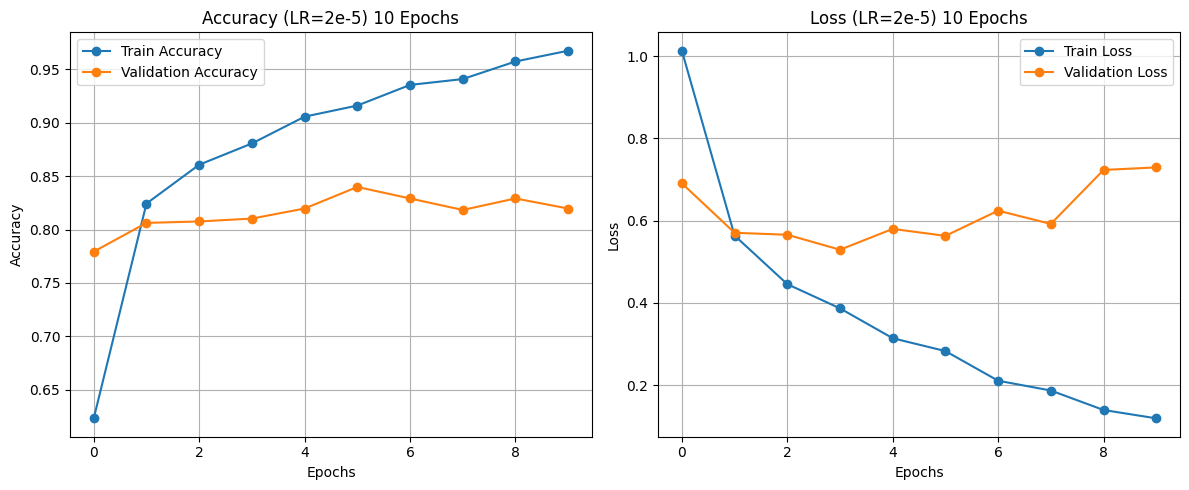

In [11]:
# Visualisasi Learning Curve
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy (LR=2e-5) 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss (LR=2e-5) 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
print(" XLM-R 10 epoch Evaluate")

# Evaluasi training
train_loss, train_acc = model.evaluate(train_dataset, verbose=0)
print(
    f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

# Evaluasi validasi untuk ringkasan
val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
print(
    f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

# Evaluasi testing
test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(
    f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

 XLM-R 10 epoch Evaluate
Training Loss: 0.0559 | Training Accuracy: 0.9859
Validation Loss: 0.7295 | Validation Accuracy: 0.8197
Test Loss: 0.6672 | Test Accuracy: 0.8291


In [13]:
# Evaluasi
pred_logits = model.predict(test_dataset).logits
pred_labels = np.argmax(pred_logits, axis=1)
true_labels = np.array(test_labels)
label_names = le.classes_.tolist()

print("\nClassification Report:")
print(classification_report(
    true_labels, 
    pred_labels,
    target_names=label_names, 
    digits=4))

47/47 [==============================] - 3s 51ms/step

Classification Report:
              precision    recall  f1-score   support

       Cinta     0.7463    0.8850    0.8097       113
     Gembira     0.8721    0.7979    0.8333       188
       Marah     0.8323    0.8535    0.8428       157
       Sedih     0.8069    0.7852    0.7959       149
       Takut     0.8779    0.8456    0.8614       136

    accuracy                         0.8291       743
   macro avg     0.8271    0.8334    0.8286       743
weighted avg     0.8325    0.8291    0.8294       743



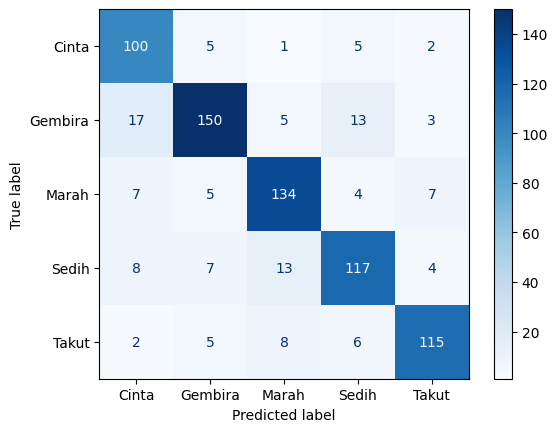

In [14]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)